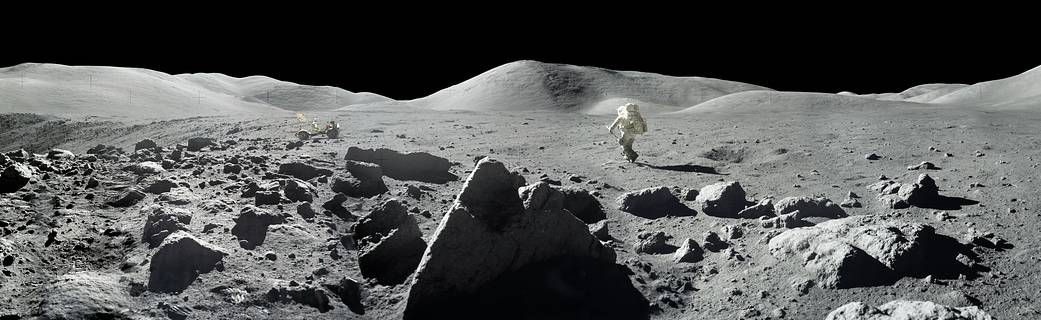

# Artificial Lunar Rocky Landscape Semantic Segmentation with U-Net Architecture 

1. About the dataset
2. Data Visualization 
3. Data Preprocessing 
4. U-Net Architecture
5. Compiling the model 
6. Predictions + Model Performance
7. Notes on Model Performance
9. Final thoughts

## About the Dataset

This dataset contains 9766 realistic renders of lunar landscapes and their masks (segmented into three classes: sky, small rocks, bigger rocks). Additionally, a csv file of bounding boxes and cleaned masks of ground truths are provided. 

An interesting feature of this dataset is that the images are synthetic; they were created using Planetside Software's Terragen. This isn't too obvious immediately as the renderings are highly realistic but it does make more sense after taking into account the scarcity of space imagery data. 

Acknowledgment: Romain Pessia and Genya Ishigami of the Space Robotics Group, Keio University, Japan. You can find the dataset [here](http://www.kaggle.com/romainpessia/artificial-lunar-rocky-landscape-dataset). 

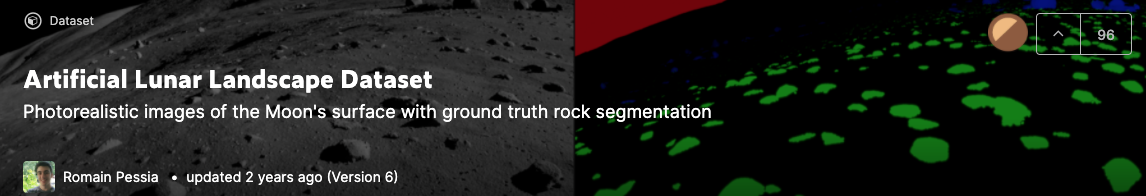

## Data Visualization

Let's start by visualizing some of the images using opencv and exploring the data some more. 

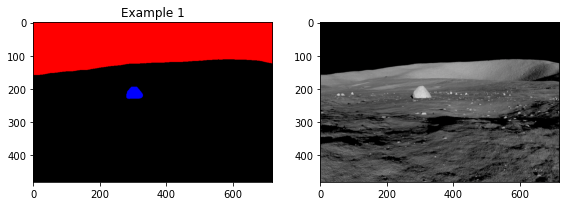

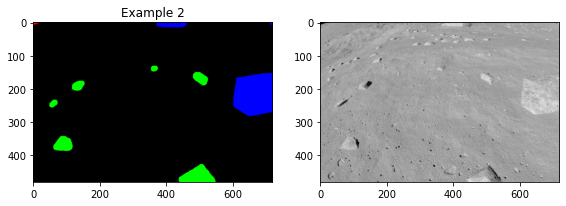

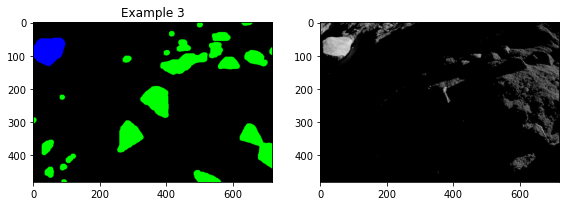

In [1]:
import matplotlib.pyplot as plt
import cv2

filepath = "../input/artificial-lunar-rocky-landscape-dataset/images/"

def showImages(dim, file, imgid,file2, imgid2, title):
    plt.figure(figsize=(dim,dim))
    plt.subplot(6,6,1)
    plt.title(title)
    img = cv2.imread(filepath + file + '/' + imgid)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.subplot(6,6,1+1)
    img2 = cv2.imread(filepath + file2 + '/' + imgid2)  
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    plt.imshow(img2)
    
    
showImages(30, 'clean', 'clean0001.png', 'render', 'render0001.png', 'Example 1')
showImages(30, 'clean', 'clean0002.png', 'render', 'render0002.png', 'Example 2')
showImages(30, 'clean', 'clean0003.png', 'render', 'render0003.png', 'Example 3')

## Data Preprocessing

Now, we will preprocess the data. Essentially, we're reading in the images and masks and replacing that array with an empty array of 0s. Then performing train test split on the arrays to split the data 20-80% into test and train samples.

In [2]:
import cv2 
import os
import numpy as np


InputPath = "../input/artificial-lunar-rocky-landscape-dataset/images/"

image_path = InputPath + 'render'
mask_path = InputPath + 'ground'

img_height = 128
img_width = 128
img_size = 128

files = sorted(next(os.walk(image_path))[2])
files2 = sorted(next(os.walk(mask_path))[2])

X = np.zeros((len(files), img_height, img_width, 3), dtype=np.uint8)
y = np.zeros((len(files2), img_height, img_width, 3), dtype=np.uint8)

X = X.astype(np.float32)
y = y.astype(np.float32)

for i, id_ in enumerate(files):
    images = os.path.join(image_path + "/" + id_)
    img = cv2.imread(images, 1)
    img = cv2.resize(img, (img_size, img_size))
    img = np.expand_dims(img, axis=0)
    X[i] = img

for i, id_ in enumerate(files2):
    masks = os.path.join(mask_path + "/" + id_)
    mask = cv2.imread(masks, 1)
    mask = cv2.resize(mask, (img_size, img_size))
    mask = np.expand_dims(mask, axis=0)
    y[i] = mask

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [4]:
X_train.shape

(8789, 128, 128, 3)

In [5]:
train_generator = zip(X_train, y_train)
test_generator = zip(X_test, y_test)

def modelInputs(train_generator):
    for (img,mask) in train_generator:
        images = img.reshape(1, 128, 128, 3)
        masks = mask.reshape(1, 128, 128, 3)
        yield (images,masks)

## The Tversky Loss

The Tversky loss is an asymmetric similarity measure that compares the ground truths and generated masks. It is somewhat of a generalization of dice coefficent and tanimoto coefficient. The following loss code was written by:

@url -> https://gist.github.com/robinvvinod/60d61a3ca642ddd826cf1e6c207cb421

@author -> robinvvinod

In [6]:
import keras.backend as K

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

## The U-Net Architecture

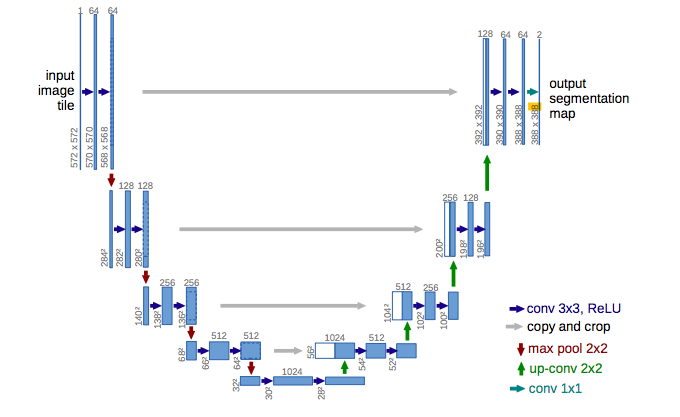

The U-Net architecture is well known for its use in biomedical imaging segmentation but has since then been a common architecture used in all kinds of image segmentation applications. Called U-Net for its distinctly U-shaped symmetrical shape, the architecture follows an encoder-decoder approach. The encoder is used to downsample inputs into feature representations at different levels and the decoder is used to upsample or generate the segmented mask using outputs from the encoder. This architecture will be used for this task of multiclass semantic segmentation. 

In [7]:
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.metrics import MeanIoU


def unet(input_size=(128, 128, 3)):
    input = Input(input_size)

    conv1 = Conv2D(filters=16, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(input)
    drop1 = Dropout(0.1)(conv1)
    conv1 = Conv2D(filters=16, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(drop1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(pool1)
    drop2 = Dropout(0.1)(conv2)
    conv2 = Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(drop2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(pool2)
    drop3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(drop3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(pool3)
    drop4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal")(drop4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", activation="relu")(pool4)
    drop5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", activation="relu")(drop5)

    # Expanding/Upsampling path
    conv6 = Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv5)
    concat6 = concatenate([conv6, conv4])
    conv6 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", activation="relu")(concat6)
    drop6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", activation="relu")(drop6)

    conv7 = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv6)
    concat7 = concatenate([conv7, conv3])
    conv7 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", activation="relu")(concat7)
    drop7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", activation="relu")(drop7)

    conv8 = Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv7)
    concat8 = concatenate([conv8, conv2])
    conv8 = Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="normal", activation="relu")(concat8)
    drop8 = Dropout(0.1)(conv8)
    conv8 = Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="normal", activation="relu")(drop8)

    conv9 = Conv2DTranspose(filters=16, kernel_size=(2, 2), strides=(2, 2), padding="same")(conv8)
    concat9 = concatenate([conv9, conv1], axis=3)
    conv9 = Conv2D(filters=16, kernel_size=(3, 3), padding="same", kernel_initializer="normal", activation="relu")(concat9)
    drop9 = Dropout(0.1)(conv8)
    conv9 = Conv2D(filters=16, kernel_size=(3, 3), padding="same", kernel_initializer="normal", activation="relu")(conv9)

    output = Conv2D(3, (1, 1), activation="softmax")(conv9)

    model = Model(inputs=[input], outputs=[output])

    model.compile(optimizer = Adam(lr = 1e-4), loss =tversky_loss,metrics=["accuracy"])

    return model

## Compiling the Model

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

model = unet()
        
model_checkpoint = ModelCheckpoint('Lunar.h5', monitor='loss',verbose=1, save_best_only=True)
model.fit(modelInputs(train_generator),steps_per_epoch=187,epochs=47,callbacks=[model_checkpoint])

Epoch 1/47
187/187 [==============================] - 23s 113ms/step - loss: -0.0689 - accuracy: 0.3186

Epoch 00001: loss improved from inf to -0.21226, saving model to Lunar.h5
Epoch 2/47
187/187 [==============================] - 21s 110ms/step - loss: -0.2310 - accuracy: 0.2792

Epoch 00002: loss improved from -0.21226 to -0.24313, saving model to Lunar.h5
Epoch 3/47
187/187 [==============================] - 21s 112ms/step - loss: -0.2625 - accuracy: 0.3022

Epoch 00003: loss improved from -0.24313 to -0.27150, saving model to Lunar.h5
Epoch 4/47
187/187 [==============================] - 21s 110ms/step - loss: -0.2775 - accuracy: 0.3058

Epoch 00004: loss did not improve from -0.27150
Epoch 5/47
187/187 [==============================] - 21s 110ms/step - loss: -0.2806 - accuracy: 0.2995

Epoch 00005: loss improved from -0.27150 to -0.29599, saving model to Lunar.h5
Epoch 6/47
187/187 [==============================] - 21s 110ms/step - loss: -0.2920 - accuracy: 0.3070

Epoch 00006

## Predictions + Model Performance

In [9]:
from keras.models import load_model

AstroModel = load_model('Lunar.h5', custom_objects={'tversky_loss': tversky_loss})     

In [10]:
import cv2

def Predictions(imgid1):

    plt.figure(figsize=(30,30))
    plt.subplot(5,5,1)

    img = cv2.imread(InputPath + "render/" + imgid1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(128,128))
    img = img.reshape(1,128,128,3)

    prediction = AstroModel.predict(img)
    
    prediction = prediction.reshape(128, 128, 3)
    prediction = cv2.resize(prediction, (710, 470))
    plt.title("Prediction")
    plt.imshow(prediction)

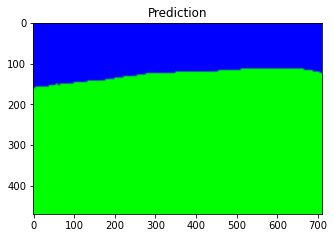

In [11]:
Predictions("render0001.png")

In [12]:
def GroundTruth(imgid):

    img2 = cv2.imread(InputPath + "clean/" + imgid)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    plt.title("Ground truth")
    plt.imshow(img2)

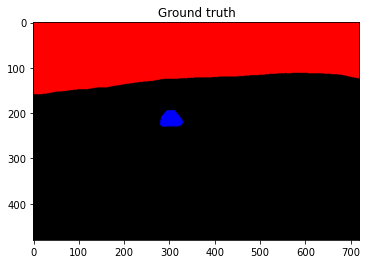

In [13]:
GroundTruth("clean0001.png")

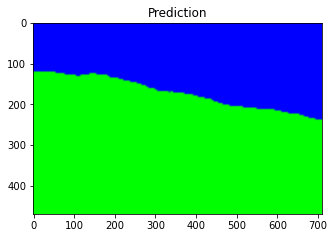

In [14]:
Predictions("render0940.png")

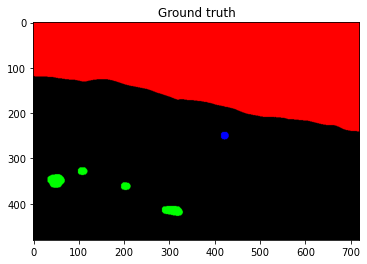

In [15]:
GroundTruth("clean0940.png")

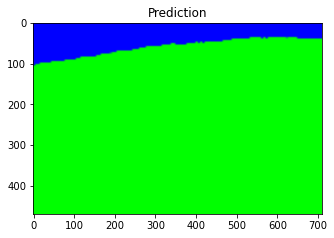

In [16]:
Predictions("render9700.png")

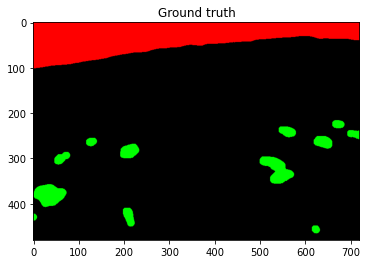

In [17]:
GroundTruth("clean9700.png")

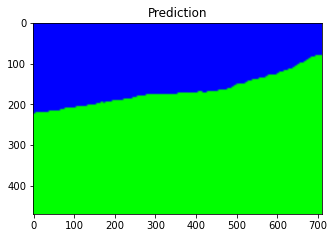

In [18]:
Predictions("render0134.png")

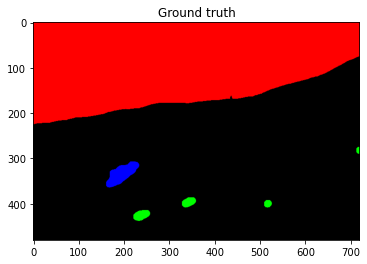

In [19]:
GroundTruth("clean0134.png")

## Notes on Model Performance

I wasn't the happiest with the predictions the model generated. It did quite well segmenting the sky and the surface, but we want the model to segment the rocks too. I did a bit more research into different losses and tried tweaking the learning rates plus added ReduceLROnPlateau checkpoint but it still wasn't doing too well. If anyone has any ideas as to how I can improve the model's performance for multi-class segmentation or can see any issues in the model causing this problem, please let me know!

## Final Thoughts

If I were to improve this model, I would play around a bit more with data augmentation. Maybe changing the contrasts of the renders would be beneficial in helping the model differentiate between the rocks and the surface and not just the lunar landscape and the sky. 


I would also look into experimenting more with different backbones/encoders for the U-net architecture and observing the difference in performances. Might be useful in improving the accuracy. 

Also, I would probably look more into the use of other losses (meanIOU, etc).

Space data is hard to come by; synthetic or not, this was an interesting one to work with!

Again, if anyone has any ideas as to how to improve the model, I'd be interested in hearing them in the comments!

Check out some of my other notebooks: 

[Designing Convolutional Neural Networks with MNIST dataset](http://www.kaggle.com/tenzinmigmar/fashion-mnist)

[Galaxy Multi-Image Classification with LeNet-5](http://www.kaggle.com/tenzinmigmar/galaxy-multi-image-classification-with-lenet-5)